In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import optuna
from optuna.samplers import TPESampler

from mypackage import dir

In [2]:
# Environment variables
project = 'belgium'
data = dir.make_dir(project) 
processed = data('processed')
outputs = data('outputs')

In [3]:
# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

In [4]:
df = cargar_datos('df_hotel_transformados')
df.head()

Loaded table: df_hotel_transformados


,text,label,id,texto,longitud,importancia_tfidf
0,mejor lugar comer sushi excelente lugar comer ...,2,1,el mejor lugar para comer sushi. excelente lug...,127,3.833645
1,vista hermosa sorprendio maravillosa vista ciu...,2,2,vista hermosa!. me sorprendió la maravillosa v...,174,4.635010
2,desastroso buenas noches explicar hotel dos oc...,0,3,"desastroso. buenas noches, ante todo explicar...",505,7.507874
3,bien excepto niegan dar vasos agua pesar ser r...,1,4,todo bien excepto que se niegan a dar vasos de...,219,3.936997
4,mejor zologico mexico ambiente agradable poder...,2,5,el mejor zoologico de méxico. el ambiente es m...,102,3.567779


In [5]:
X = df['text']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=4000,  use_idf=True, min_df=10)
class_weights = {0: 2.0, 1: 0.5, 2: 0.1}

model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                               class_weight=class_weights,
                               random_state=42,
                               max_iter=1000))
])
model.fit(X_train, y_train)

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, min_df=10,
                                 ngram_range=(1, 3))),
                ('clf',
                 LogisticRegression(class_weight={0: 2.0, 1: 0.5, 2: 0.1},
                                    max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [8]:
y_pred = model.predict(X_test)

In [9]:
print("--- Evaluación del Modelo ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
# print(f"Accuracy: {recall_score(y_test, y_pred):.2f}\n")

--- Evaluación del Modelo ---
Accuracy: 0.88



In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.69      0.55       616
           1       0.47      0.62      0.53      3261
           2       0.96      0.91      0.94     26147

    accuracy                           0.88     30024
   macro avg       0.63      0.74      0.67     30024
weighted avg       0.90      0.88      0.89     30024



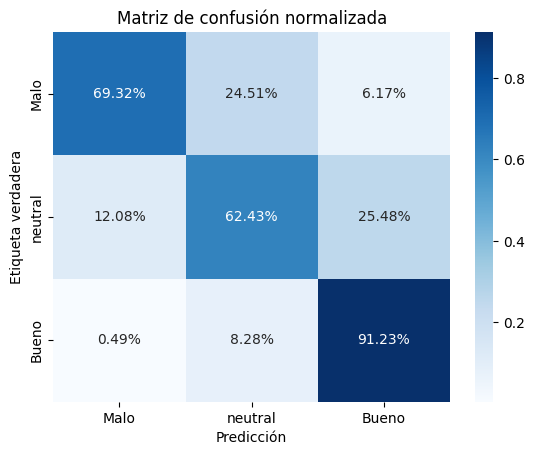

In [11]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ["Malo", "neutral", "Bueno"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')

plt.savefig(outputs / 'matriz_confusion_modelo_regresion_logistica.png')
plt.show()

In [12]:
model2 = Pipeline([
    ('tfidf', vectorizer),
    ('rf', RandomForestClassifier(n_estimators=20, 
                                  class_weight=class_weights,
                                  random_state=42))
])
model2.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=4000, min_df=10,
                                 ngram_range=(1, 3))),
                ('rf',
                 RandomForestClassifier(class_weight={0: 2.0, 1: 0.5, 2: 0.1},
                                        n_estimators=20, random_state=42))])

In [13]:
y_pred2 = model2.predict(X_test)

In [14]:
print("--- Evaluación del Modelo ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred2):.2f}\n")
# print(f"Accuracy: {recall_score(y_test, y_pred2):.2f}\n")

--- Evaluación del Modelo ---
Accuracy: 0.89



In [15]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.63      0.25      0.36       616
           1       0.61      0.26      0.37      3261
           2       0.91      0.99      0.95     26147

    accuracy                           0.89     30024
   macro avg       0.72      0.50      0.56     30024
weighted avg       0.87      0.89      0.87     30024



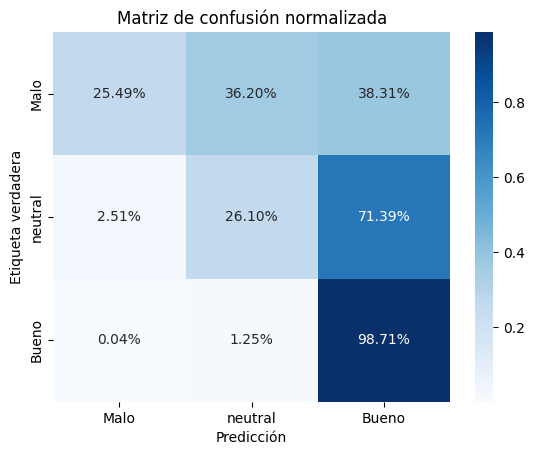

In [16]:
cm = confusion_matrix(y_test, y_pred2, normalize='true')
class_labels = ["Malo", "neutral", "Bueno"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')

plt.savefig(outputs / 'matriz_confusion_modelo_random_forest.png')
plt.show()

## Optimizacion

In [19]:
def objective(trial):
    # Definir ngram_range como strings y convertirlos después a tuplas
    ngram_str = trial.suggest_categorical('ngram_range', ['1-1', '1-2', '2-2', '1-3'])
    ngram_range = tuple(map(int, ngram_str.split('-')))  # Convierte "1-2" → (1, 2)

    params = {
        'tfidf__ngram_range': ngram_range,  # Usamos la tupla convertida
        'tfidf__max_features': trial.suggest_int('max_features', 1000, 10000, step=1000),
        'tfidf__min_df': trial.suggest_int('min_df', 1, 5),
        'tfidf__use_idf': trial.suggest_categorical('use_idf', [True, False]),
    }

    # Pipeline con TfidfVectorizer + Clasificador (ej: LogisticRegression)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(class_weight=class_weights, 
                                   random_state=42, 
                                   max_iter=1000))
    ])

    # Asignar los parámetros al pipeline
    pipeline.set_params(**params)

    score = cross_val_score(pipeline, X, y, cv=3, scoring='recall_macro').mean()
    return score


In [21]:
# Crear el estudio
study_name = "comentarios2"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name, 
                            direction='maximize',
                            storage=storage_name,
                            pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                            sampler=TPESampler())
study.optimize(objective, n_trials=20)

[I 2025-07-21 15:22:53,220] A new study created in RDB with name: comentarios2
[I 2025-07-21 15:24:56,887] Trial 0 finished with value: 0.7408171325338677 and parameters: {'ngram_range': '1-3', 'max_features': 9000, 'min_df': 3, 'use_idf': False}. Best is trial 0 with value: 0.7408171325338677.
[I 2025-07-21 15:25:23,939] Trial 1 finished with value: 0.7384417386864378 and parameters: {'ngram_range': '1-1', 'max_features': 4000, 'min_df': 1, 'use_idf': True}. Best is trial 0 with value: 0.7408171325338677.
[I 2025-07-21 15:26:22,469] Trial 2 finished with value: 0.5941864511940255 and parameters: {'ngram_range': '2-2', 'max_features': 4000, 'min_df': 1, 'use_idf': True}. Best is trial 0 with value: 0.7408171325338677.
[I 2025-07-21 15:27:25,207] Trial 3 finished with value: 0.7417171163625235 and parameters: {'ngram_range': '1-2', 'max_features': 9000, 'min_df': 1, 'use_idf': False}. Best is trial 3 with value: 0.7417171163625235.
[I 2025-07-21 15:28:10,427] Trial 4 finished with value

In [22]:
df_study = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_study = df_study.sort_values(by=['value'], ascending=False)
df_study.to_csv(f'{outputs}/{study_name}.csv', encoding = 'utf-8-sig', index = False)
df_study.head(10)

,number,value,params_max_features,params_min_df,params_ngram_range,params_use_idf,state
17,17,0.742519,10000,4,1-3,False,COMPLETE
15,15,0.742519,10000,4,1-3,False,COMPLETE
14,14,0.742519,10000,4,1-3,False,COMPLETE
11,11,0.741898,10000,5,1-3,False,COMPLETE
12,12,0.741898,10000,5,1-3,False,COMPLETE
3,3,0.741717,9000,1,1-2,False,COMPLETE
19,19,0.741298,6000,3,1-3,False,COMPLETE
18,18,0.740960,8000,4,1-3,False,COMPLETE
0,0,0.740817,9000,3,1-3,False,COMPLETE
13,13,0.740719,7000,5,1-3,False,COMPLETE


In [23]:
# Mejores parámetros encontrados
print("Mejor precisión:", study.best_value)
print("Mejores parámetros:", study.best_params)

Mejor precisión: 0.7425194634629518
Mejores parámetros: {'ngram_range': '1-3', 'max_features': 10000, 'min_df': 4, 'use_idf': False}


In [24]:
hiper = study.best_params
hiper

{'ngram_range': '1-3', 'max_features': 10000, 'min_df': 4, 'use_idf': False}

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             max_features=hiper['max_features'],  
                             min_df=hiper['min_df'], 
                             use_idf=hiper['use_idf'])

model_tune = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(solver='lbfgs', 
                               class_weight=class_weights, 
                               random_state=42, 
                               max_iter=1000))
])
model_tune.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, min_df=4,
                                 ngram_range=(1, 3), use_idf=False)),
                ('clf',
                 LogisticRegression(class_weight={0: 2.0, 1: 0.5, 2: 0.1},
                                    max_iter=1000, random_state=42))])

In [26]:
y_pred_tune = model_tune.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred_tune))

              precision    recall  f1-score   support

           0       0.47      0.71      0.57       616
           1       0.47      0.63      0.54      3261
           2       0.96      0.91      0.94     26147

    accuracy                           0.88     30024
   macro avg       0.64      0.75      0.68     30024
weighted avg       0.90      0.88      0.89     30024



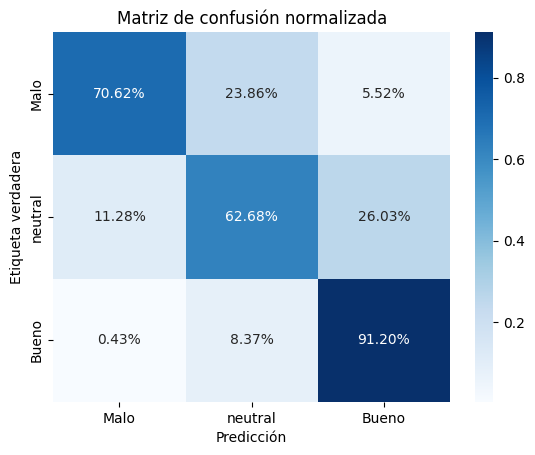

In [28]:
cm = confusion_matrix(y_test, y_pred_tune, normalize='true')
class_labels = ["Malo", "neutral", "Bueno"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')

plt.savefig(outputs / 'matriz_confusion_modelo_tune.png')
plt.show()

In [29]:
df['pred'] = model_tune.predict(df['text'])
df.head()

,text,label,id,texto,longitud,importancia_tfidf,pred
0,mejor lugar comer sushi excelente lugar comer ...,2,1,el mejor lugar para comer sushi. excelente lug...,127,3.833645,2
1,vista hermosa sorprendio maravillosa vista ciu...,2,2,vista hermosa!. me sorprendió la maravillosa v...,174,4.635010,2
2,desastroso buenas noches explicar hotel dos oc...,0,3,"desastroso. buenas noches, ante todo explicar...",505,7.507874,0
3,bien excepto niegan dar vasos agua pesar ser r...,1,4,todo bien excepto que se niegan a dar vasos de...,219,3.936997,1
4,mejor zologico mexico ambiente agradable poder...,2,5,el mejor zoologico de méxico. el ambiente es m...,102,3.567779,2


In [30]:
resultado = df[(df['label'] == 0) & (df['pred'] == 1)]
resultado.head()

,text,label,id,texto,longitud,importancia_tfidf,pred
263,monserrate si buen lugar alla arriba costoso d...,0,264,monserrate si y no. buen lugar allá arriba en ...,201,5.291596,1
301,falta mantenimiento notoria falta mantenimient...,0,302,falta mantenimiento. es notoria la falta de ma...,182,4.436576,1
1382,decepcionante demasiado demorado check in dos ...,0,1382,decepcionante. demasiado demorado el check in ...,351,3.421016,1
2022,bodeguita miedo ver leyenda queda encanto cuba...,0,2021,"la bodeguita "" del miedo"". nada que ver con la...",165,5.788042,1
2110,mal servicio falta profesionalismo personas en...,0,2109,mal servicio. falta de profesionalismo de las ...,326,3.960554,1


In [31]:
resultado.iloc[0]['texto']

'monserrate si y no. buen lugar allá arriba en mi es muy costoso todo son 20 dólares una comida, es inseguro roban por modo chalequeo o sea ladrones ágiles que no emplean violencia y el uso del teleférico es muy costoso todo es costoso en monserrate lo bueno realmente es la vista tomarse fotos!'

In [34]:
resultado.shape

(440, 7)

In [35]:
resultado2 = df[(df['label'] == 1) & (df['pred'] == 0)]
resultado2.shape

(1733, 7)

In [32]:
print('ok_')

ok_
